In [33]:
import methods
import oracles
import plot_trajectory_2d
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import numpy as np

# Quadratic function. Gradient descent

In [2]:
def get_condition_number(A):
    eigenvalues = np.abs(np.linalg.eigvals(A))
    return max(eigenvalues) / min(eigenvalues)

## Зависимость от числа обусловленности

In [3]:
As = [
    np.eye(2),
    np.array([[3, 1], [1, 2]]),
    np.array([[1, 2], [2, 5]]),
]
b = np.array([1, 2])
x0 = np.array([-0.5, -0.5])

In [4]:
line_search_options = [{'method': 'Constant', 'color': 'r'}, 
                       {'method': 'Armijo', 'color': 'g'}, 
                       {'method': 'Wolfe', 'color': 'b'}]

Criteria was satisfied
Criteria was satisfied
Criteria was satisfied


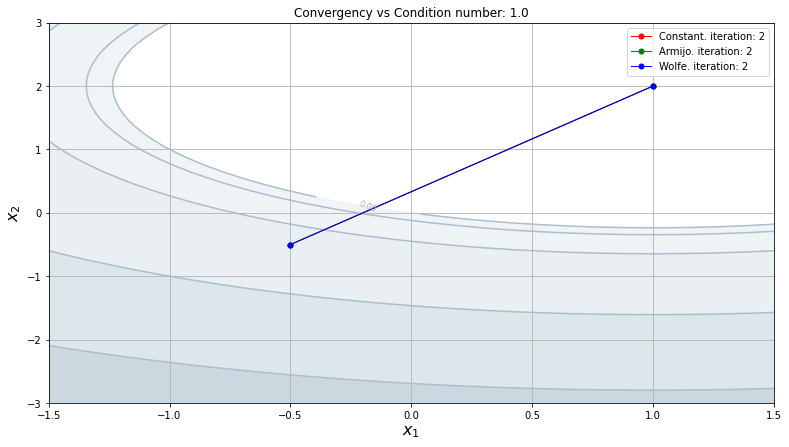

Number of iterations exceeded
Number of iterations exceeded
Criteria was satisfied


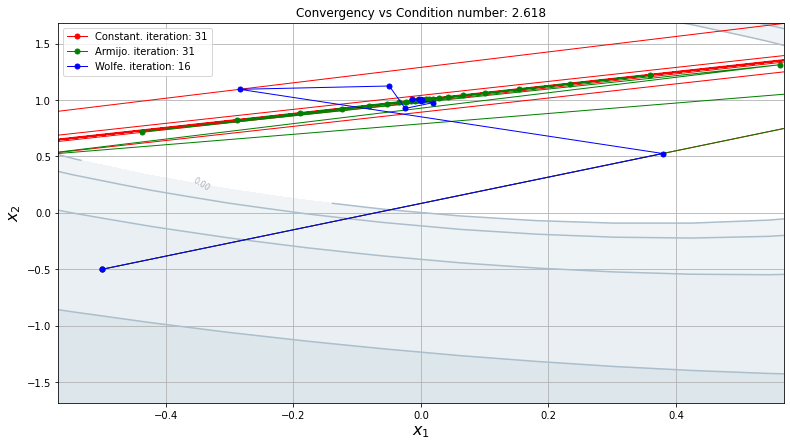

Number of iterations exceeded
Number of iterations exceeded
Number of iterations exceeded


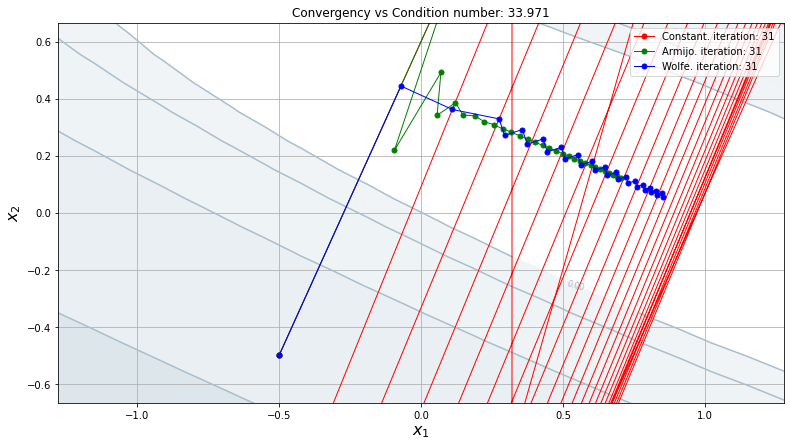

In [5]:
for A in As:
    quadratic = oracles.QuadraticOracle(A, b)
    plt.figure(figsize=(13, 7))
    plot_trajectory_2d.plot_levels(quadratic.func)
    for line_search_option in line_search_options:
        method = methods.GradientDescent(quadratic, x0, tolerance=1e-10, line_search_options=line_search_option)
        method.run(30)
        plot_trajectory_2d.plot_trajectory(quadratic.func, method.hist['x'], fit_axis=True,
                                           label=f'{line_search_option["method"]}. iteration: {len(method.hist["x"])}',
                                           color=line_search_option['color'])
    plt.legend()
    plt.title(f'Convergency vs Condition number: {get_condition_number(A):.5}')
    plt.xlabel('$x_1$', fontsize='16')
    plt.ylabel('$x_2$', fontsize='16')
    plt.show()

## Зависимость от начальной точки

In [6]:
A = np.array([[3, 1], [1, 2]])
b = np.array([1, 2])
x0s = [np.array([-0.5, -0.5]), np.array([2, 2]), np.array([10, 7])]
line_search_options = [
                       {'method': 'Armijo', 'color': 'g'}, 
                       {'method': 'Wolfe', 'color': 'b'}]

Criteria was satisfied
Criteria was satisfied


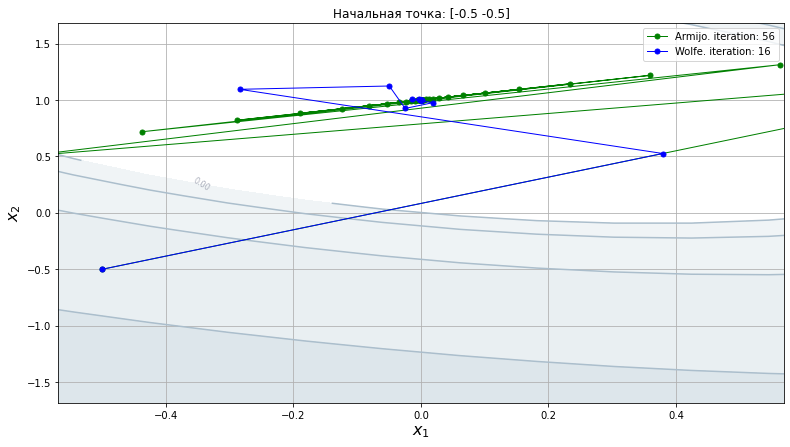

Criteria was satisfied
Criteria was satisfied


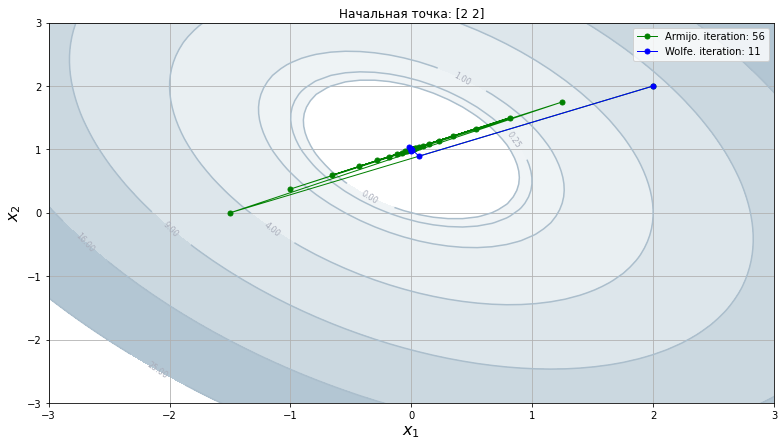

Criteria was satisfied
Criteria was satisfied


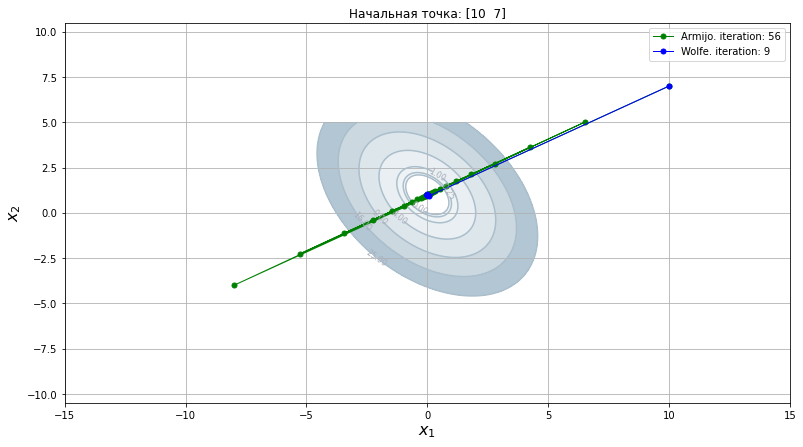

In [7]:
for x0 in x0s:
    quadratic = oracles.QuadraticOracle(A, b)
    plt.figure(figsize=(13, 7))
    plot_trajectory_2d.plot_levels(quadratic.func)
    for line_search_option in line_search_options:
        method = methods.GradientDescent(quadratic, x0, tolerance=1e-10, line_search_options=line_search_option)
        method.run(100)
        plot_trajectory_2d.plot_trajectory(quadratic.func, method.hist['x'], fit_axis=True,
                                           label=f'{line_search_option["method"]}. iteration: {len(method.hist["x"])}',
                                           color=line_search_option['color'])
    plt.legend()
    plt.title(f'Начальная точка: {x0}')
    plt.xlabel('$x_1$', fontsize='16')
    plt.ylabel('$x_2$', fontsize='16')
    plt.show()

# 2.2 Выводы

- Чем больше число обусловленности, тем дольше сходятся методы (появляется характерный зигзаг, особенно при плохом выборе начальной точки)
- Зависимость от стартовой точки
    - Алгоритм постоянного шага, при котором он сходится, сходится быстрее если стартовая точка ближе к решению
    - Алгоритм с правилом Армихо не зависит от стартовой точки
    - Алгоритм с правилом Вульфа сходится дольше если начальная точка ближе к решению(т.к. начинает перелетать решение)
- Константный алгоритм зачастую не сходится
- Алгоритм с правилом Армихо сходится, но на сколько быстро зависит от параметров
- Алгоритм с правилом Вульфа сходится быстро практически независимо от параметров

# Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

In [19]:
import os, sys


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [20]:
from tqdm.notebook import tqdm

In [31]:
condition_numbers = np.arange(1, 251, step=10)
dimensions = [10, 100, 1000]
num_samples = 20

In [32]:
res = np.empty((len(dimensions), len(condition_numbers), num_samples))
with HiddenPrints():
    for i, n in tqdm(enumerate(dimensions), desc="dimensions", position=0, leave=True, total=len(dimensions)):
        for j, k in tqdm(enumerate(condition_numbers), desc="condition_numbers", position=1, leave=False, total=len(condition_numbers)):
            for l, _ in enumerate(range(num_samples)):
                eigenvalue = [1] + list(np.random.uniform(1, k, size=n-2)) + [k]
                A = np.diag(eigenvalue)
                b = np.random.normal(size=n)
                x0 = np.random.normal(size=n)
                quadratic = oracles.QuadraticOracle(A, b)
                method = methods.GradientDescent(quadratic, x0, tolerance=1e-10, line_search_options={'method': 'Wolfe'})
                method.run(1000)
                res[i, j, l] = len(method.hist["func"])

dimensions:   0%|          | 0/3 [00:00<?, ?it/s]

condition_numbers:   0%|          | 0/25 [00:00<?, ?it/s]

condition_numbers:   0%|          | 0/25 [00:00<?, ?it/s]

condition_numbers:   0%|          | 0/25 [00:00<?, ?it/s]

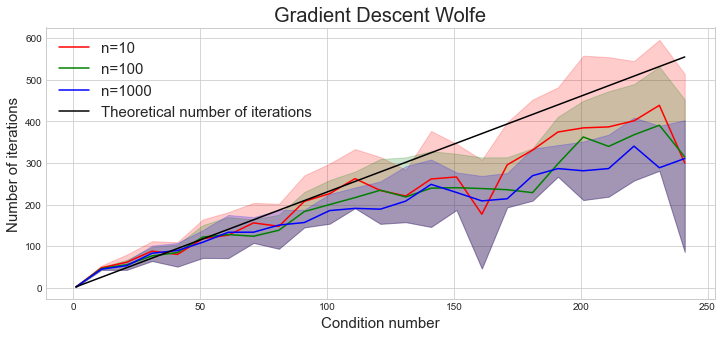

In [68]:
plt.figure(figsize=(12, 5))
colors = ['r', 'g', 'b']
for i in range(len(dimensions)):
    plt.plot(condition_numbers, res[i].mean(axis=1), color=colors[i], label=f'n={dimensions[i]}')
    plt.fill_between(condition_numbers, res[0].mean(axis=1) - res[0].std(axis=1),
                     res[i].mean(axis=1) + res[i].std(axis=1), alpha=.2, color=colors[i])
plt.plot(condition_numbers, condition_numbers * np.log(1/1e-10) / 10, color='k', label='Theoretical number of iterations')
plt.title('Gradient Descent Wolfe', fontsize=20)
plt.ylabel('Number of iterations', fontsize=15)
plt.xlabel('Condition number', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.show()

# 2.3 Выводы

- Линейная зависимость числа итераций градиентного спуска от числа обусловленности
- С ростом размерности число итераций не увеличивается
- Согласуется с теорией

# Градиентный спуск на задаче логистической регрессии

In [69]:
from sklearn.datasets import load_svmlight_file

In [97]:
import subprocess


datasets = ['a9a', 'gisette_scale.bz2', 'real-sim.bz2']
for dataset in datasets:
    subprocess.call(['wget', '-nv', f'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset}'])

2023-03-10 17:00:41 URL:https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a [2329875/2329875] -> "a9a.4" [1]
2023-03-10 17:00:47 URL:https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2 [21902461/21902461] -> "gisette_scale.bz2.3" [1]
2023-03-10 17:00:54 URL:https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2 [35214832/35214832] -> "real-sim.bz2.2" [1]


  0%|          | 0/3 [00:00<?, ?it/s]

Criteria was satisfied
Criteria was satisfied
Criteria was satisfied


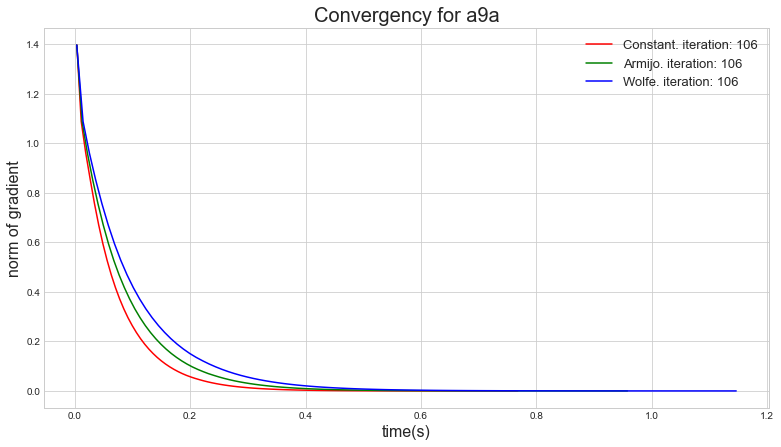

Number of iterations exceeded
Number of iterations exceeded
Number of iterations exceeded


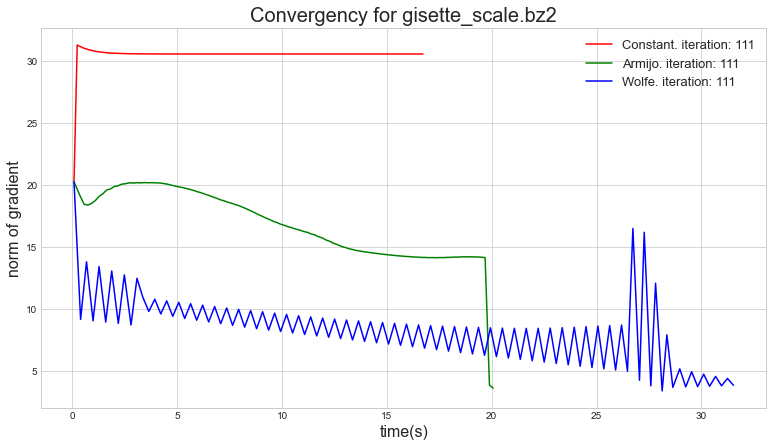

Criteria was satisfied
Criteria was satisfied
Criteria was satisfied


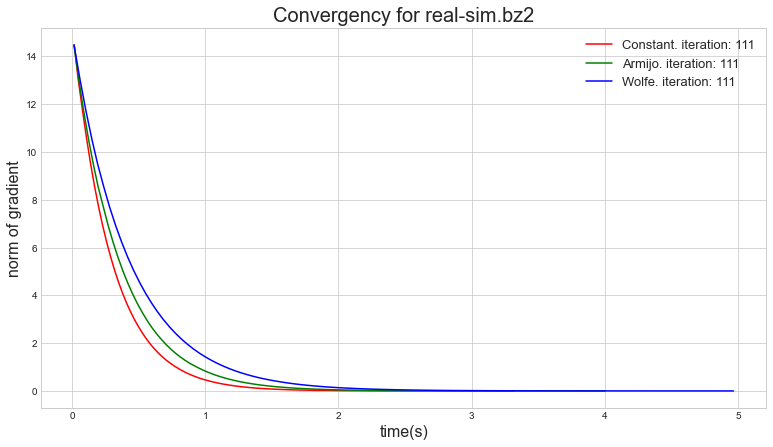

In [114]:
REG = 0.1
line_search_options = [{'method': 'Constant', 'color': 'r'}, 
                       {'method': 'Armijo', 'color': 'g'}, 
                       {'method': 'Wolfe', 'color': 'b'}]


for dataset in tqdm(datasets):
    A, b = load_svmlight_file(dataset)
    logreg = oracles.create_log_reg_oracle(A, b, REG)
    x0 = np.random.normal(size=A.shape[1])
    plt.figure(figsize=(13, 7))
    for line_search_option in line_search_options:
        method = methods.GradientDescent(logreg, x0, tolerance=1e-10, line_search_options=line_search_option)
        method.run(110)
        plt.plot(method.hist['time'], method.hist['grad_norm'],
                 label=f'{line_search_option["method"]}. iteration: {len(method.hist["func"])}',
                 color=line_search_option['color'])
    plt.legend(fontsize='13')
    plt.title(f'Convergency for {dataset}', fontsize=20)
    plt.xlabel('time(s)', fontsize='16')
    plt.ylabel('norm of gradient', fontsize='16')
    plt.show()

# 2.4 Выводы

Т.к. функция потерь выпукла, можно подобрать постоянный шаг, который даст быструю(по времени) сходимость, как для датасетов `a9a` и `real-sim`. Однако подбор шага может быть сложной задачей или если у нас может нет возможности запускать градиентный спуск много раз. В таких случаях стоит воспользоваться правилом Армихо или Вульфа. Вульф надежнее, но работает дольше всех. 